# Coursework 4: CIFAR-100

## A study in Very Deep Convolutional Neural Networks

In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import datetime
import os
from collections import OrderedDict
import time
import tflearn
import tensorflow.contrib.slim as slim
import pickle as pcl

%matplotlib inline
plt.style.use('ggplot')

config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.allow_growth = True

train_data = CIFAR100DataProvider('train', batch_size=50)
valid_data = CIFAR100DataProvider('valid', batch_size=50)
test_inputs = np.load(os.path.join(os.environ['MLP_DATA_DIR'], 'cifar-100-test-inputs.npz'))['inputs']

valid_inputs = valid_data.inputs
valid_targets = valid_data.to_one_of_k(valid_data.targets)

def weight_variable(shape, i):
    initial = tf.contrib.layers.variance_scaling_initializer()
    return tf.get_variable('W_'+i,shape=shape,initializer=initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def write_to_file(newfile, run_info):
    with open(newfile,'wb') as outfile:
        pcl.dump(run_info,outfile)

def read_from_file(newfile):
    file = open(newfile,'rb')
    run_info = pcl.load(file)
    return run_info

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
def plot_error_and_accuracy(diction, filename):
    fig = plt.figure(figsize=(12, 6))
    fig2 = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax3 = fig2.add_subplot(1,2,1)
    ax4 = fig2.add_subplot(1,2,2)
    x=np.arange(30) +1
    for labels, run in diction.items():
        error_all, acc_all, error_valid_all, acc_valid_all = run
        ax1.plot(x, 
                 error_all, label=str(labels))
        ax2.plot(x, 
                 error_valid_all, label=str(labels))
        ax3.plot(x, 
                 acc_all, label=str(labels))
        ax4.plot(x, 
                 acc_valid_all, label=str(labels))

    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    #ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    fig.tight_layout() 
    fig.savefig(filename+'_err.png') 
    #ax2.set_yscale('log')
    
    
    ax3.legend(loc=0)
    ax3.set_xlabel('Epoch number')
    ax3.set_ylabel('Training set accuracy')
    ax4.legend(loc=0)
    ax4.set_xlabel('Epoch number')
    ax4.set_ylabel('Validation set accuracy')
    fig2.tight_layout() # This minimises whitespace around the axes.
    fig2.savefig(filename+'_acc.png') # Save figure to current directory in PDF format
    plt.show()

### Baseline Model

In [3]:
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

run_info = {}
labels = ['1_layer','3_layers','5_layers', '8_layers', '14_layers']
num_layers = [1,3,5,8,14]
hidden_l = [None]*15

for label, num_layer in zip(labels,num_layers):

    tf.reset_default_graph()
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])


    
    
        with tf.name_scope('fc-layer-1'):
            fc_1 = fully_connected_layer(x, train_data.inputs.shape[1], 600, tf.nn.relu)
            batch1 = batch(fc_1,is_training_ph, 'first')
            hidden_l[0] = tf.nn.dropout(batch1, keep_prob) 
        for i in range(1,num_layer):
            with tf.name_scope('fc-layer-' + str(i+1)):
                fc = fully_connected_layer(hidden_l[i-1], 600, 600, tf.nn.relu)
                batch_l = batch(fc,is_training_ph, str(i))
                hidden_l[i] = tf.nn.dropout(batch_l, keep_prob) 
                
        with tf.name_scope('output-layer'):
            y_out = fully_connected_layer(hidden_l[num_layer-1], 600, train_data.num_classes, tf.identity)
        

        with tf.name_scope('error'):
            net_vars   = tf.trainable_variables()  
            lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in net_vars
                       if 'biases' not in v.name ]) 
            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + lossL2*0.0001),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=0.01,momentum=0.9).minimize(error)

        init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    _, batch_error, batch_acc = sess.run(
                        [train_step, error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, keep_prob: 0.8})
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False, keep_prob:1})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 1_layer
End of epoch 01: err(train)=4.2092 acc(train)=0.1007
                 err(valid)=3.7815 acc(valid)=0.1408
-- 6.4216344356536865 secs ---
End of epoch 02: err(train)=3.8425 acc(train)=0.1467
                 err(valid)=3.6425 acc(valid)=0.1564
-- 6.270145416259766 secs ---
End of epoch 03: err(train)=3.7297 acc(train)=0.1636
                 err(valid)=3.5763 acc(valid)=0.1720
-- 6.065902471542358 secs ---
End of epoch 04: err(train)=3.6801 acc(train)=0.1719
                 err(valid)=3.5630 acc(valid)=0.1716
-- 6.056562662124634 secs ---
End of epoch 05: err(train)=3.6564 acc(train)=0.1765
                 err(valid)=3.5467 acc(valid)=0.1772
-- 6.040847301483154 secs ---
End of epoch 06: err(train)=3.6443 acc(train)=0.1780
                 err(valid)=3.5667 acc(valid)=0.1642
-- 6.0657854080200195 secs ---
End of epoch 07: err(train)=3.6449 acc(train)=0.1762
                 err(valid)=3.5137 acc(valid)=0.1896
-- 6.0686047077178955 secs ---
End of epoch 08: err(train)=3.

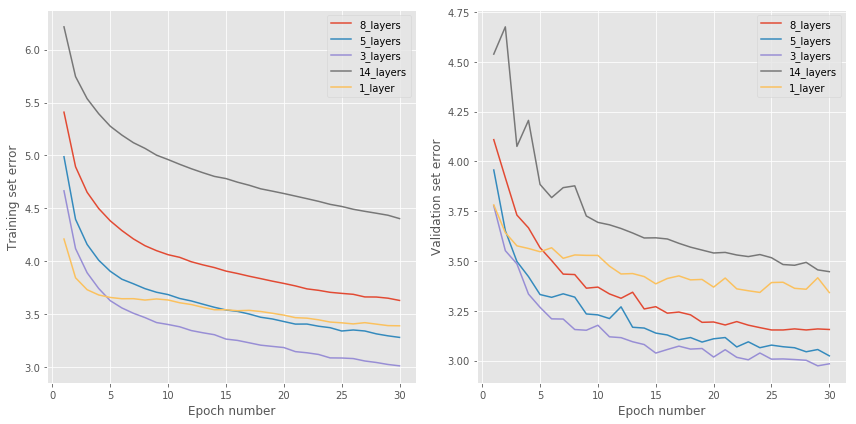

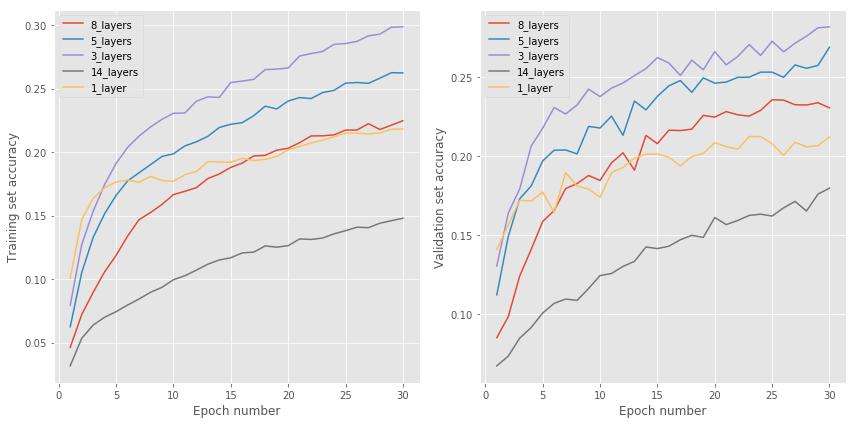

In [4]:
write_to_file('CIFAR100_baseline.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR100_baseline')

## VGG Network

In [6]:
def stackUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("stack_unit"+str(i)):

        part1 = slim.conv2d(input_layer,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part2 = batch(part1,is_training_ph, str(i)+"_"+str(1))
        part3 = tf.nn.relu(part2)
        
        part4 = slim.conv2d(part3,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part5 = batch(part4,is_training_ph, str(i)+"_"+str(2))
        output = tf.nn.relu(part5)
        
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1, keep_prob: 0.5})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01, keep_prob:0.5})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001, keep_prob:0.5})
    return batch_error, batch_acc

In [8]:
run_info = {}
labels = ['8_layers','14_layers','20_layers']
num_layers = [1,2,3]

for label, num_layer in zip(labels,num_layers):
    filters = [16,32,64]
    tf.reset_default_graph()
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3
        layer1 = x_image

        for i in range(3):
            print (i)
            for j in range(num_layer):
                print (j)
                layer1 = stackUnit(layer1,j + 3*i, filters[i], j , i, is_training_ph)
            layer1 = max_pool_2x2(layer1)

        res = tf.reshape(layer1,[-1, 4*4*64])

        with tf.name_scope('fully_connected_stack'):
            w_1 = weight_variable([4*4*64, 1024], str(1))
            b1 = bias_variable([1024])
            fc1 = tf.matmul(res, w_1) + b1
            batch1 = batch(fc1,is_training_ph, "fc1")
            nofc1 = tf.nn.relu(batch1)
            drop1 = tf.nn.dropout(nofc1, keep_prob)

            w_2 = weight_variable([4*4*64, 1024], str(2))
            b2 = bias_variable([1024])
            fc2 = tf.matmul(drop1, w_2) + b2
            batch2 = batch(fc2,is_training_ph, "fc2")
            nofc2 = tf.nn.relu(batch2)
            drop2 = tf.nn.dropout(nofc2, keep_prob)

            w_3 = weight_variable([1024, 100], str(3))
            b3 = bias_variable([100])
            y_out = tf.matmul(drop2, w_3) + b3    

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            regularizers = regularizers = tf.reduce_sum(tf.square(w_1)) + tf.reduce_sum(tf.square(w_2)) + tf.reduce_sum(tf.square(w_3))
            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.00001*regularizers+tf.reduce_sum(reg_losses))),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            #with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
            train_step =tf.train.MomentumOptimizer(learning_rate=0.1,momentum=0.9).minimize(error)

        init = tf.global_variables_initializer()

    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False, keep_prob:1})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))



0
0
1
0
2
0
Model: 8_layers
End of epoch 01: err(train)=4.6112 acc(train)=0.0461
                 err(valid)=3.9230 acc(valid)=0.0841
-- 30.699381113052368 secs ---
End of epoch 02: err(train)=4.0132 acc(train)=0.0928
                 err(valid)=3.6998 acc(valid)=0.1240
-- 30.184804916381836 secs ---
End of epoch 03: err(train)=3.8334 acc(train)=0.1205
                 err(valid)=3.5317 acc(valid)=0.1533
-- 30.218136072158813 secs ---
End of epoch 04: err(train)=3.7041 acc(train)=0.1428
                 err(valid)=3.3639 acc(valid)=0.1841
-- 30.41013216972351 secs ---
End of epoch 05: err(train)=3.5968 acc(train)=0.1646
                 err(valid)=3.2803 acc(valid)=0.2143
-- 30.479913473129272 secs ---
End of epoch 06: err(train)=3.4879 acc(train)=0.1842
                 err(valid)=3.2087 acc(valid)=0.2159
-- 30.399523973464966 secs ---
End of epoch 07: err(train)=3.4151 acc(train)=0.2002
                 err(valid)=3.0995 acc(valid)=0.2416
-- 30.283283710479736 secs ---
End of epoch 0

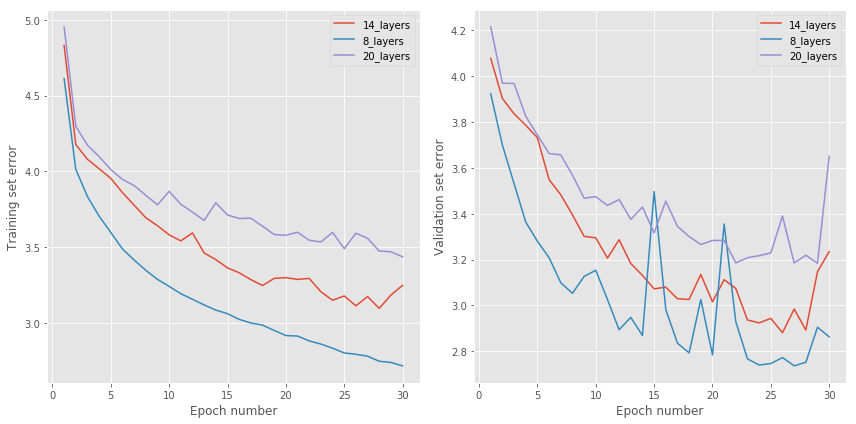

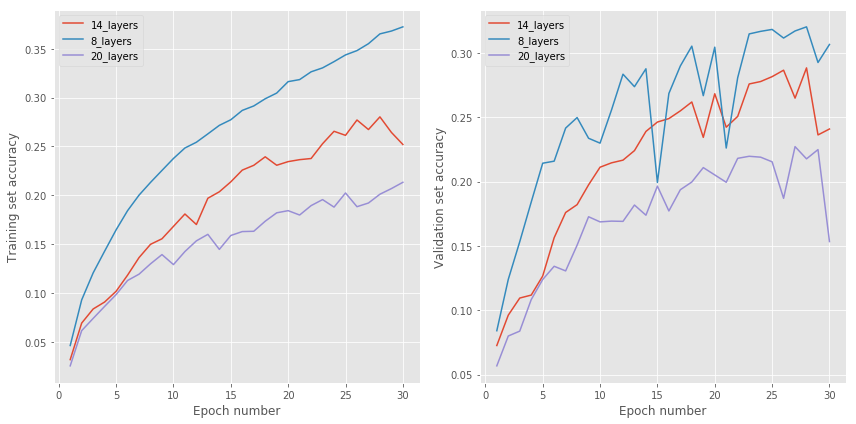

In [9]:
write_to_file('CIFAR100_VGG_net.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR100_VGG')


# Plain Deep Network

In [3]:
def stackUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("stack_unit"+str(i)):

        part1 = slim.conv2d(input_layer,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part2 = batch(part1,is_training_ph, str(i)+"_"+str(1))
        part3 = tf.nn.relu(part2)
        
        part4 = slim.conv2d(part3,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.00001))
        
        part5 = batch(part4,is_training_ph, str(i)+"_"+str(2))
        output = tf.nn.relu(part5)
        
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1, keep_prob: 0.5})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01, keep_prob:0.5})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001, keep_prob:0.5})
    return batch_error, batch_acc

In [4]:
run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0))
        layer1 = batch(layer1,is_training_ph, 'first')
        layer1 = tf.nn.relu(layer1)
        for i in range(3):
            for j in range(num_layer):
                layer1 = stackUnit(layer1,j + num_layer*i, filters[i], j , i, is_training_ph)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],stride=[2,2],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))
            layer1 = batch(layer1, is_training_ph, str(j + 3*i)+"_"+str(3))
            layer1 = tf.nn.relu(layer1)

        layer1 = batch(layer1, is_training_ph, "out2")
        layer1 = tf.nn.relu(layer1)    
        output_layer = slim.conv2d(layer1,100,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.0001),scope='conv_top')

        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([100, 100], str(1))
        b_fc2 = bias_variable([100])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))




Model: 24_layers
End of epoch 01: err(train)=4.2963 acc(train)=0.0466
                 err(valid)=3.9164 acc(valid)=0.0872
-- 88.79290699958801 secs ---
End of epoch 02: err(train)=3.8342 acc(train)=0.1156
                 err(valid)=3.7741 acc(valid)=0.1203
-- 86.13819456100464 secs ---
End of epoch 03: err(train)=3.6441 acc(train)=0.1475
                 err(valid)=3.6602 acc(valid)=0.1478
-- 85.74454712867737 secs ---
End of epoch 04: err(train)=3.5186 acc(train)=0.1707
                 err(valid)=3.3896 acc(valid)=0.1804
-- 86.00749611854553 secs ---
End of epoch 05: err(train)=3.4185 acc(train)=0.1924
                 err(valid)=3.4030 acc(valid)=0.1824
-- 86.03721880912781 secs ---
End of epoch 06: err(train)=3.3368 acc(train)=0.2070
                 err(valid)=3.2977 acc(valid)=0.2051
-- 86.25198030471802 secs ---
End of epoch 07: err(train)=3.2719 acc(train)=0.2246
                 err(valid)=3.2147 acc(valid)=0.2214
-- 86.24398732185364 secs ---
End of epoch 08: err(train)=3.2

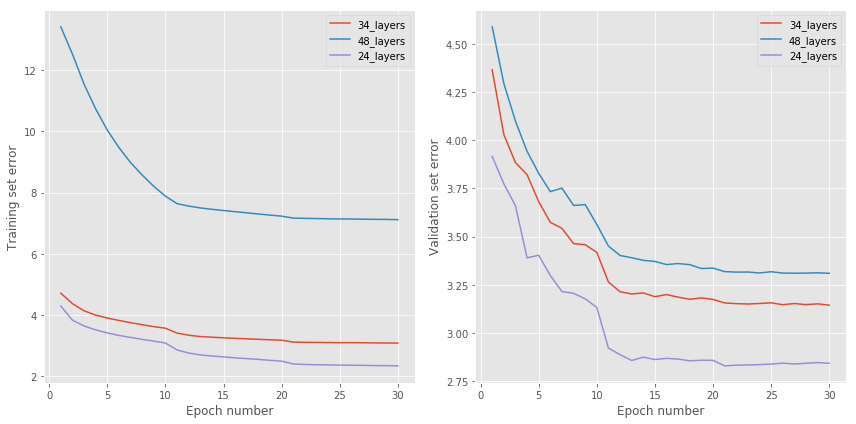

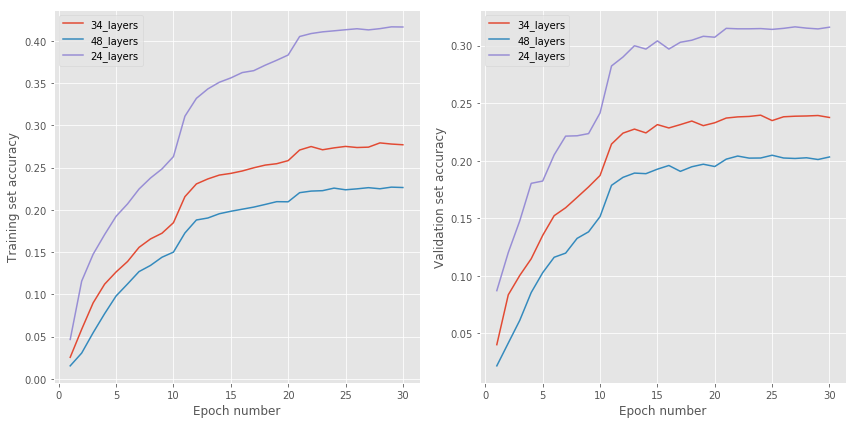

In [5]:
write_to_file('CIFAR100_PlainNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR100_PlainNet')

# Residual Network

In [6]:
def resUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = batch(input_layer,is_training_ph, str(i)+"_"+str(1))
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001))
        #print (part3.shape)
        part4 = batch(part3, is_training_ph, str(i)+"_"+str(2))
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001))
        #print (part4.shape)
        if j==0 and k!=0:
            input_padded = tf.pad(input_layer, [[0, 0], [0, 0], [0, 0], [filters // 4, filters // 4]])
            #print (input_paded.shape)
            output = input_padded + part6 # change to input padded
        else:
            output = input_layer + part6
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001})
    return batch_error, batch_acc
        

run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.001),
                             scope='conv_'+str(0))
        for i in range(3):
            
            for j in range(num_layer):
                layer1 = resUnit(layer1,j + num_layer*i, filters[i], j , i, is_training_ph)
            layer1 = batch(layer1, is_training_ph, str(j + 3*i)+"_"+str(3))
            layer1 = tf.nn.relu(layer1)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],stride=[2,2],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))

        layer1 = batch(layer1, is_training_ph, "out2")
        layer1 = tf.nn.relu(layer1)    
        output_layer = slim.conv2d(layer1,100,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.001),scope='conv_top')

        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([100, 100], str(1))
        b_fc2 = bias_variable([100])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 24_layers
End of epoch 01: err(train)=4.5484 acc(train)=0.0956
                 err(valid)=3.6996 acc(valid)=0.1261
-- 87.34332418441772 secs ---
End of epoch 02: err(train)=3.8290 acc(train)=0.1695
                 err(valid)=3.5299 acc(valid)=0.1600
-- 86.59678030014038 secs ---
End of epoch 03: err(train)=3.6108 acc(train)=0.2083
                 err(valid)=3.1669 acc(valid)=0.2226
-- 90.37618660926819 secs ---
End of epoch 04: err(train)=3.4741 acc(train)=0.2417
                 err(valid)=3.1790 acc(valid)=0.2298
-- 86.787846326828 secs ---
End of epoch 05: err(train)=3.3756 acc(train)=0.2677
                 err(valid)=3.0856 acc(valid)=0.2365
-- 86.90777373313904 secs ---
End of epoch 06: err(train)=3.3120 acc(train)=0.2833
                 err(valid)=3.1223 acc(valid)=0.2458
-- 86.53496408462524 secs ---
End of epoch 07: err(train)=3.2661 acc(train)=0.2973
                 err(valid)=3.1978 acc(valid)=0.2408
-- 86.93706560134888 secs ---
End of epoch 08: err(train)=3.238

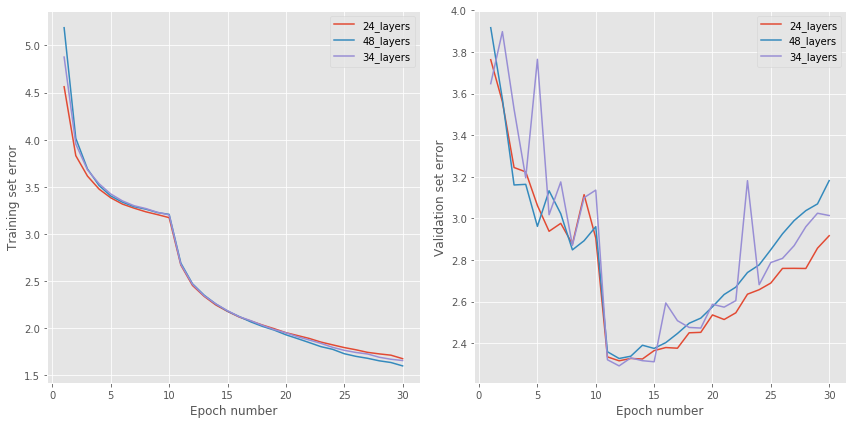

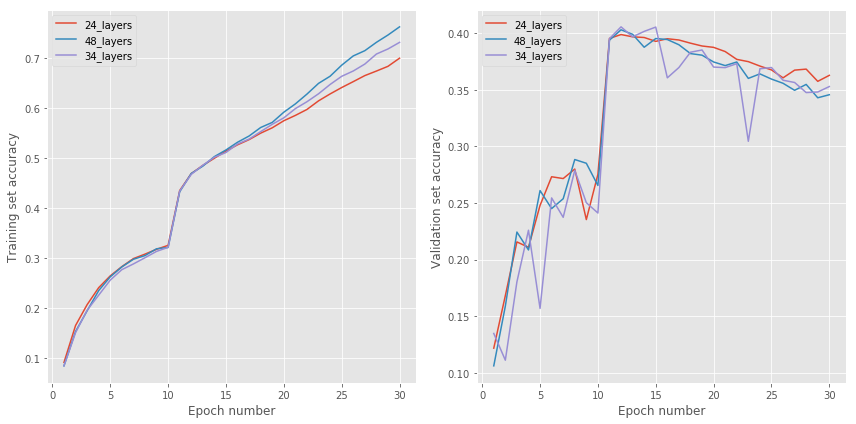

In [7]:
run_info = read_from_file('CIFAR100_ResNet.txt')
plot_error_and_accuracy(run_info, 'CIFAR100_ResNet')

### Option B

In [4]:
def resUnit(input_layer,i, filters, j , k, is_training_ph):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = batch(input_layer,is_training_ph, str(i)+"_"+str(1))
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001))
        #print (part3.shape)
        part4 = batch(part3, is_training_ph, str(i)+"_"+str(2))
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,filters,[3,3],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001))
        #print (part4.shape)
        if j==0 and k!=0:
            input_padded = slim.conv2d(input_layer,filters,[1,1],activation_fn=None,\
                            weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001))
            #print (input_paded.shape)
            output = input_padded + part6 # change to input padded
        else:
            output = input_layer + part6
        return output
    
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.8, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001})
    return batch_error, batch_acc
        

run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.001),
                             scope='conv_'+str(0))
        for i in range(3):
            
            for j in range(num_layer):
                layer1 = resUnit(layer1,j + num_layer*i, filters[i], j , i, is_training_ph)
            layer1 = batch(layer1, is_training_ph, str(j + 3*i)+"_"+str(3))
            layer1 = tf.nn.relu(layer1)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],stride=[2,2],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))

        layer1 = batch(layer1, is_training_ph, "out2")
        layer1 = tf.nn.relu(layer1)    
        output_layer = slim.conv2d(layer1,100,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.001),scope='conv_top')

        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([100, 100], str(1))
        b_fc2 = bias_variable([100])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))



Model: 24_layers
End of epoch 01: err(train)=4.4413 acc(train)=0.0907
                 err(valid)=3.5642 acc(valid)=0.1469
-- 86.41957449913025 secs ---
End of epoch 02: err(train)=3.8488 acc(train)=0.1693
                 err(valid)=3.3446 acc(valid)=0.1894
-- 88.62804317474365 secs ---
End of epoch 03: err(train)=3.6403 acc(train)=0.2094
                 err(valid)=3.2338 acc(valid)=0.2045
-- 88.67749977111816 secs ---
End of epoch 04: err(train)=3.5146 acc(train)=0.2385
                 err(valid)=3.1215 acc(valid)=0.2291
-- 88.87116694450378 secs ---
End of epoch 05: err(train)=3.4304 acc(train)=0.2620
                 err(valid)=3.1028 acc(valid)=0.2398
-- 89.14196848869324 secs ---
End of epoch 06: err(train)=3.3884 acc(train)=0.2743
                 err(valid)=3.1836 acc(valid)=0.2390
-- 89.98775815963745 secs ---
End of epoch 07: err(train)=3.3515 acc(train)=0.2860
                 err(valid)=2.9686 acc(valid)=0.2578
-- 89.66356563568115 secs ---
End of epoch 08: err(train)=3.3

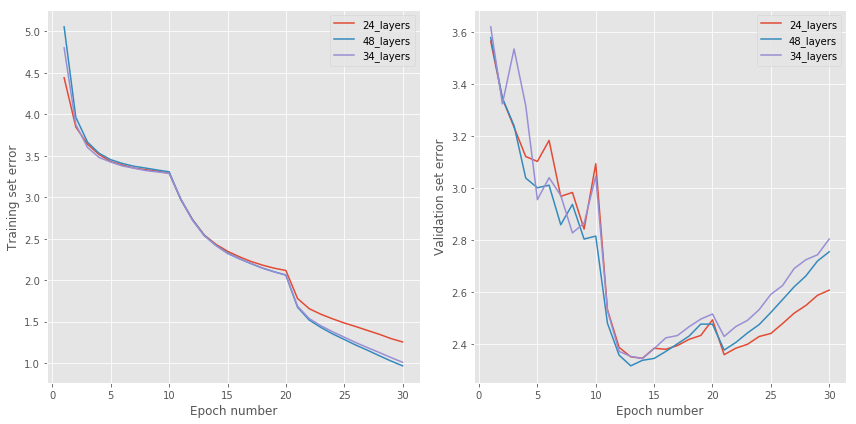

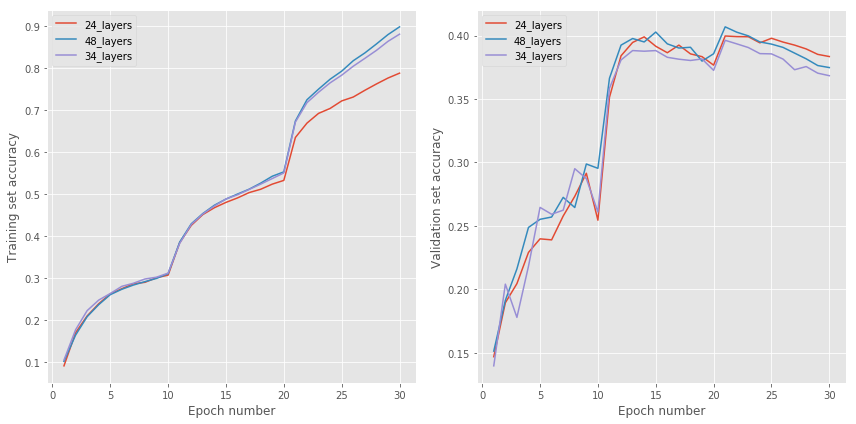

In [5]:
write_to_file('CIFAR100_ResNet_optB.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR100_ResNet_optB')

# Highway Network

In [4]:
def highwayUnit(input_layer,i,filters,j , k):
    with tf.variable_scope("highway_unit"+str(i)):
        H = slim.conv2d(input_layer,filters,[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001))
        T = slim.conv2d(input_layer,filters,[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                            weights_regularizer=slim.l2_regularizer(0.001),\
                            biases_initializer=tf.constant_initializer(-1.0),activation_fn=tf.nn.sigmoid)
        
        if j==0 and k!=0:
            input_padded = tf.pad(input_layer, [[0, 0], [0, 0], [0, 0], [filters // 4, filters // 4]])
            output = H*T + input_padded*(1.0-T) # change to input padded
        else:
            output = H*T + input_layer*(1.0-T)
        return output

def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001})
    return batch_error, batch_acc
        
run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph

    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)
        
        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3
        layer1 = slim.conv2d(x_image,16,[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                weights_regularizer=slim.l2_regularizer(0.001),normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
        for i in range(3):
            for j in range(num_layer):
                layer1 = highwayUnit(layer1,j + (i*num_layer), filters[i], j , i)
            layer1 = slim.conv2d(layer1,filters[i],[3,3],weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                weights_regularizer=slim.l2_regularizer(0.001),stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))

        top = slim.conv2d(layer1,100,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')


        top_c = tflearn.global_avg_pool(top)

        W_fc2 = weight_variable([100, 100], str(1))
        b_fc2 = bias_variable([100])
        y_out = tf.matmul(top_c, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
                #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)

        init = tf.global_variables_initializer()
        
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 24_layers
End of epoch 01: err(train)=4.4102 acc(train)=0.1219
                 err(valid)=3.4663 acc(valid)=0.1696
-- 61.649999141693115 secs ---
End of epoch 02: err(train)=3.7436 acc(train)=0.1918
                 err(valid)=3.2847 acc(valid)=0.2081
-- 59.982507944107056 secs ---
End of epoch 03: err(train)=3.5926 acc(train)=0.2225
                 err(valid)=3.1200 acc(valid)=0.2322
-- 59.98145031929016 secs ---
End of epoch 04: err(train)=3.5370 acc(train)=0.2395
                 err(valid)=3.0912 acc(valid)=0.2394
-- 59.90928673744202 secs ---
End of epoch 05: err(train)=3.5043 acc(train)=0.2508
                 err(valid)=3.0226 acc(valid)=0.2578
-- 59.89737010002136 secs ---
End of epoch 06: err(train)=3.4816 acc(train)=0.2605
                 err(valid)=2.9594 acc(valid)=0.2662
-- 59.82810378074646 secs ---
End of epoch 07: err(train)=3.4695 acc(train)=0.2669
                 err(valid)=2.9632 acc(valid)=0.2641
-- 59.87115025520325 secs ---
End of epoch 08: err(train)=3

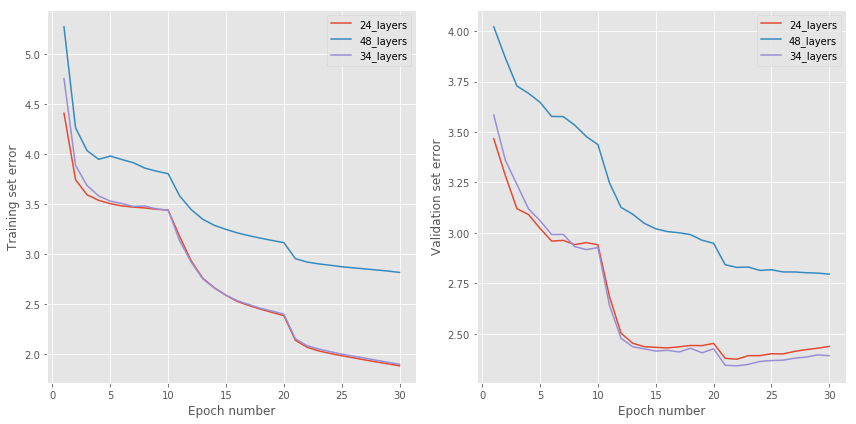

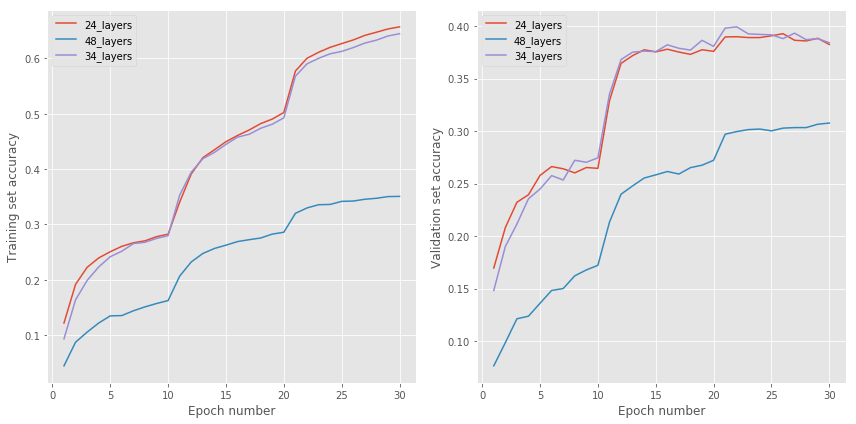

In [5]:
write_to_file('CIFAR100_HighwayNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR100_HighwayNet')

# Dense Network

In [4]:
def batch(layer_input, is_training_ph, i):
    with tf.variable_scope('bn_layer'+i) as vs:
        layer_output = tf.cond(is_training_ph,
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=True, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs),
            lambda: tf.contrib.layers.batch_norm(layer_input,decay=0.9, is_training=False, center=True, scale=True, activation_fn=None, updates_collections=None, scope=vs, reuse=True))
    return layer_output


def denseUnit(input_layer,i,j,is_training_ph, keep_prob,filters):
    with tf.variable_scope("dense_unit"+str(i)):
        nodes = []
        a = slim.conv2d(input_layer,filters,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0+j*i))
        a = batch(a,is_training_ph, str(0 + j*i))
        a = tf.nn.relu(a)
        a = tf.nn.dropout(a, keep_prob)
        nodes.append(a)
        for z in range(j):
            b = slim.conv2d(tf.concat(nodes,3),filters,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(z+1+j*i))
            b = batch(b,is_training_ph, str(z+1 + j*i))
            b = tf.nn.relu(b)
            b = tf.nn.dropout(b, keep_prob)
            nodes.append(b)
        return b
    
def decay_learning_step(e,input_batch, target_batch):
    if e <10:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.1,keep_prob:0.9})
    elif (e>10) and (e <20):
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.01,keep_prob:0.9})
    else:
        _, batch_error, batch_acc = sess.run(
            [train_step, error, accuracy], feed_dict={x: input_batch, y_: target_batch, is_training_ph: True, l_rate: 0.001,keep_prob:0.9})
    return batch_error, batch_acc

run_info = {}
labels = ['24_layers','34_layers','48_layers']
num_layers = [3,5,7]
for label, num_layer in zip(labels,num_layers):
    tf.reset_default_graph()
    filters = [16, 32, 64]
    graph = tf.Graph() #create new graph    
    with graph.as_default():
        x = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
        y_ = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
        keep_prob = tf.placeholder(tf.float32)
        is_training_ph = tf.placeholder('bool', [])
        l_rate = tf.placeholder(tf.float32)

        x_image = tf.reshape(x, [-1,32,32,3]) #batch_size, IMAGE_SIZE, IMAGE_SIZE, 3


        layer1 = slim.conv2d(x_image,16,[3,3],activation_fn=None,\
                             weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                             weights_regularizer=slim.l2_regularizer(0.0001),
                             scope='conv_'+str(0))
        layer1 = batch(layer1,is_training_ph, "first")
        layer1 = tf.nn.relu(layer1)
        
        for i in range(3):
            layer1 = denseUnit(layer1,i,num_layer,is_training_ph, keep_prob, filters[i])
            layer1 = slim.conv2d(layer1,filters[i],[1,1],activation_fn=None,\
                                 weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                 scope='conv_s_'+str(i))
            layer1 = batch(layer1,is_training_ph, "transit"+str(i))
            layer1 = tf.nn.relu(layer1)
            layer1 = tf.nn.dropout(layer1, keep_prob)
            layer1 = tf.nn.avg_pool(layer1,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        output_layer = slim.conv2d(layer1,100,[3,3],activation_fn=None,\
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(),\
                                   weights_regularizer=slim.l2_regularizer(0.0001),scope='conv_top')
        output_layer = batch(output_layer, is_training_ph, "out3")
        top_c = tf.nn.relu(output_layer)
        top_c = tf.nn.dropout(top_c, keep_prob)
        
        top = tflearn.global_avg_pool(top_c)

        W_fc2 = weight_variable([100, 100], str(1))
        b_fc2 = bias_variable([100])
        y_out = tf.matmul(top, W_fc2) + b_fc2

        with tf.name_scope('error'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

            per_datapoint_errors = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_out)
            #error = tf.reduce_mean(per_datapoint_errors)
            error = tf.cond(is_training_ph, 
                            lambda: tf.reduce_mean(per_datapoint_errors + tf.reduce_sum(0.0001*tf.square(W_fc2))+tf.reduce_sum(reg_losses)),
                            lambda: tf.reduce_mean(per_datapoint_errors))

        with tf.name_scope('accuracy'):
            per_datapoint_pred_is_correct = tf.equal(tf.argmax(y_out, axis=1), tf.argmax(y_, axis=1))
            accuracy = tf.reduce_mean(tf.cast(per_datapoint_pred_is_correct, tf.float32))

        with tf.name_scope('training'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                # Ensures that we execute the update_ops before performing the train_step
                train_step =tf.train.MomentumOptimizer(learning_rate=l_rate,momentum=0.9,use_nesterov=True).minimize(error)
        init = tf.global_variables_initializer()
        
    acc_all=[]
    error_all=[]
    acc_valid_all=[]
    error_valid_all=[]
    with tf.Session(graph=graph,config=config) as sess:
            sess.run(init)
            print('Model: {}'.format(label))
            for e in range(30):
                start_time = time.time()
                running_error = 0.
                running_accuracy = 0.
                for input_batch, target_batch in train_data:
                    batch_error, batch_acc = decay_learning_step(e,input_batch, target_batch)
                    running_error += batch_error
                    running_accuracy += batch_acc
                running_error /= train_data.num_batches
                running_accuracy /= train_data.num_batches
                error_all.append(running_error)
                acc_all.append(running_accuracy)
                if (e + 1) % 1 == 0:
                    print('End of epoch {0:02d}: err(train)={1:.4f} acc(train)={2:.4f}'
                              .format(e + 1, running_error, running_accuracy))

                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={x: input_batch, y_: target_batch, is_training_ph: False, keep_prob:1})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data.num_batches
                valid_accuracy /= valid_data.num_batches
                error_valid_all.append(valid_error)
                acc_valid_all.append(valid_accuracy)
                if (e + 1) % 1 == 0:
                    print('                 err(valid)={0:.4f} acc(valid)={1:.4f}'
                            .format(valid_error, valid_accuracy))
                print ("-- %s secs ---" % (time.time()-start_time))
            run_info[label] = (error_all,acc_all,error_valid_all, acc_valid_all)
            print('Min_Validation_Error: {0} '.format(min(error_valid_all)))
            print('Max_Validation_Accuracy: {0} '.format(max(acc_valid_all)))


Model: 24_layers
End of epoch 01: err(train)=2.2131 acc(train)=0.0257
                 err(valid)=4.3980 acc(valid)=0.0408
-- 50.1403124332428 secs ---
End of epoch 02: err(train)=3.8394 acc(train)=0.1220
                 err(valid)=3.6092 acc(valid)=0.1468
-- 91.7801558971405 secs ---
End of epoch 03: err(train)=3.5504 acc(train)=0.1733
                 err(valid)=3.9863 acc(valid)=0.1113
-- 92.52844643592834 secs ---
End of epoch 04: err(train)=3.3914 acc(train)=0.2036
                 err(valid)=3.2525 acc(valid)=0.2161
-- 92.22454929351807 secs ---
End of epoch 05: err(train)=3.2856 acc(train)=0.2256
                 err(valid)=5.1226 acc(valid)=0.0820
-- 91.77665042877197 secs ---
End of epoch 06: err(train)=3.1914 acc(train)=0.2494
                 err(valid)=3.1979 acc(valid)=0.2222
-- 91.89131951332092 secs ---
End of epoch 07: err(train)=3.1285 acc(train)=0.2663
                 err(valid)=2.8872 acc(valid)=0.2748
-- 91.67582273483276 secs ---
End of epoch 08: err(train)=3.073

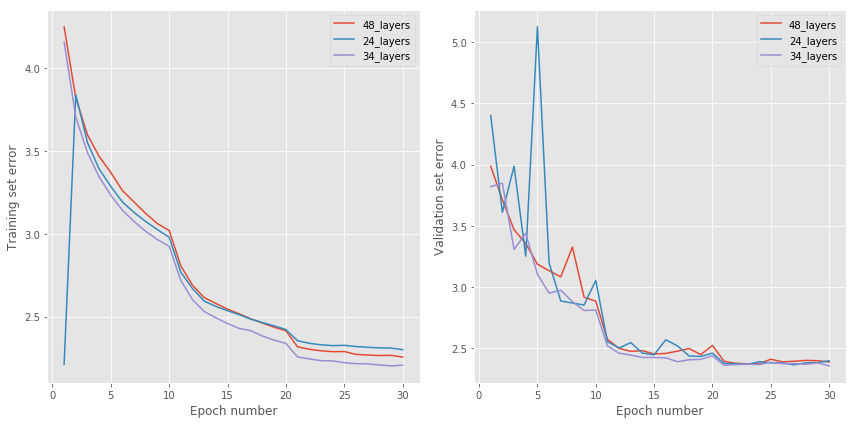

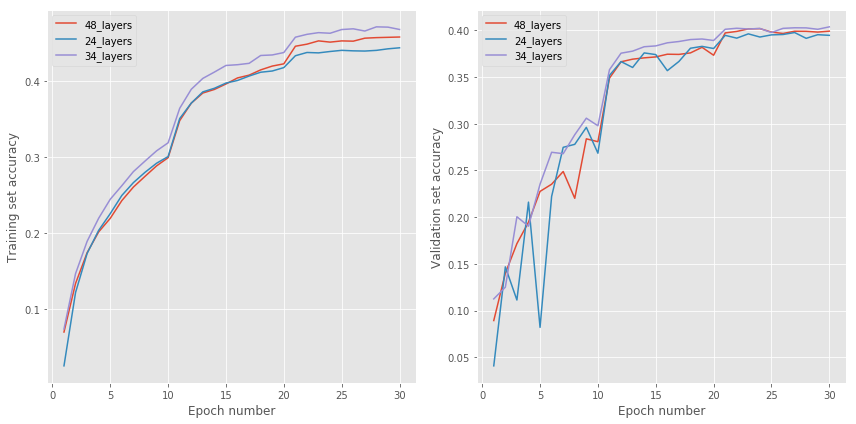

In [5]:
write_to_file('CIFAR100_DenseNet.txt', run_info)
plot_error_and_accuracy(run_info, 'CIFAR100_DenseNet')